# 挑选4张测试集中的图像，通过可视化对比训练好的Mask R-CNN第一阶段产生的proposal box和最终的预测结果

In [2]:
import mmcv
import torch
from mmdet.apis import init_detector
from mmdet.registry import VISUALIZERS
from mmdet.structures import DetDataSample
import numpy as np

Loads checkpoint by local backend from path: /cpfs04/user/cuisiwei/mmdetection/mymodels/mask_rcnn/epoch_8.pth


/root/miniconda3/envs/openmmlab/lib/python3.11/site-packages/mmengine/runner/checkpoint.py:347: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filenam

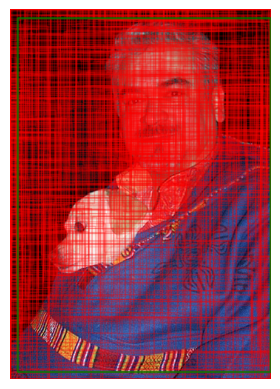

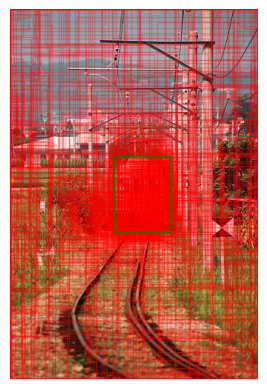

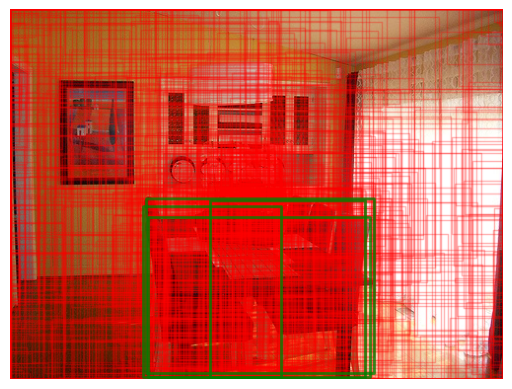

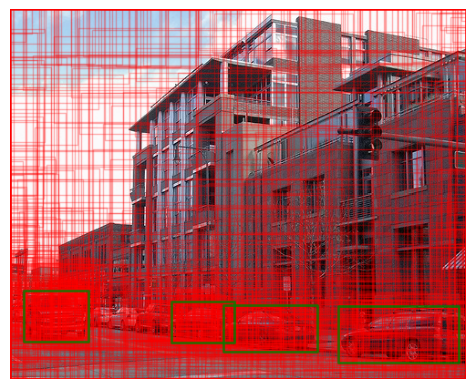

In [ ]:
from mmdet.apis import init_detector
from mmengine.structures import InstanceData
from mmengine.visualization import Visualizer
import mmcv
import torch
import matplotlib.pyplot as plt

# 初始化模型
config = 'configs/mask_rcnn/mask_rcnn_r50_fpn_1x_voc0712.py'
checkpoint = 'mymodels/mask_rcnn/epoch_8.pth'
model = init_detector(config, checkpoint, device='cuda:0')

img_paths = ['data/VOCdevkit/VOC2007/JPEGImages/000001.jpg',
             'data/VOCdevkit/VOC2007/JPEGImages/000002.jpg',
             'data/VOCdevkit/VOC2007/JPEGImages/000006.jpg',
             'data/VOCdevkit/VOC2007/JPEGImages/000004.jpg']
for i in range(4):
    # 准备数据
    img_path = img_paths[i]
    img = mmcv.imread(img_path)
    data = {
        'inputs': [torch.from_numpy(img).permute(2, 0, 1).float()],
        'data_samples': [DetDataSample(metainfo={
            'img_shape': img.shape[:2],
            'scale_factor': np.array([1., 1., 1., 1.], dtype=np.float32),
            'ori_shape': img.shape[:2]
        })]
    }

    # 获取中间结果
    with torch.no_grad():
        # 预处理
        data = model.data_preprocessor(data, False)
        # 提取特征
        x = model.extract_feat(data['inputs'])
        # 获取RPN结果
        rpn_results = model.rpn_head.predict(x, data['data_samples'])
        proposals = rpn_results[0].bboxes.cpu().numpy()
        # 获取最终结果
        det_results = model.roi_head.predict(x, rpn_results, data['data_samples'])
        det_bboxes = det_results[0].bboxes.cpu().numpy()
        det_scores = det_results[0].scores.cpu().numpy()

        # 过滤低置信度检测框
        keep = det_scores > 0.3
        det_bboxes = det_bboxes[keep]

        # 可视化
        img = mmcv.imread(img_path)
        visualizer = Visualizer.get_instance('mmdet')
        visualizer.dataset_meta = model.dataset_meta

        visualizer.set_image(img[:,:,::-1])
        # 绘制Proposals（红色半透明）
        visualizer.draw_bboxes(proposals, edge_colors='r', line_widths=1, alpha=0.3)
        # 绘制最终检测框（绿色实线）
        visualizer.draw_bboxes(det_bboxes, edge_colors='g', line_widths=2)

        vis_img = visualizer.get_image()

    # 使用 matplotlib 显示图像
    plt.figure()  
    plt.imshow(vis_img)
    plt.axis('off')  # 关闭坐标轴
    plt.show()

# Mask R-CNN 和Sparse R-CNN的实例分割与目标检测可视化结果

## Mask R-CNN

Loads checkpoint by local backend from path: mymodels/mask_rcnn/epoch_8.pth


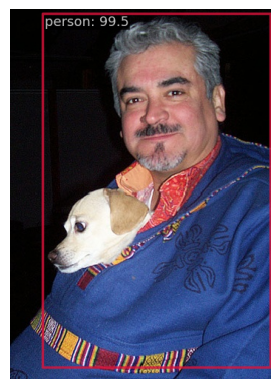

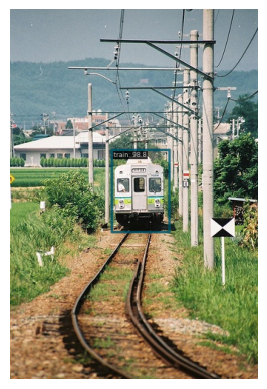

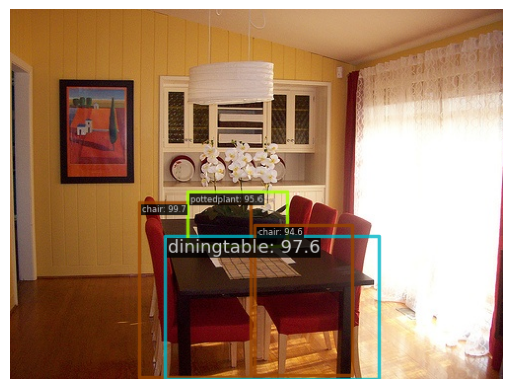

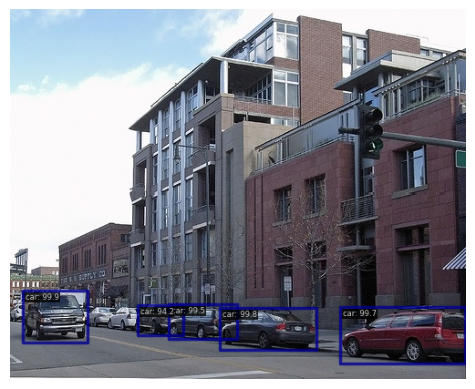

In [14]:
import mmcv
import torch
import numpy as np
from mmdet.apis import inference_detector, init_detector

# 1. 加载训练好的 Mask R-CNN 模型
config = 'configs/mask_rcnn/mask_rcnn_r50_fpn_1x_voc0712.py'
checkpoint = 'mymodels/mask_rcnn/epoch_8.pth'
model = init_detector(config, checkpoint, device='cuda:0')


img_paths = ['data/VOCdevkit/VOC2007/JPEGImages/000001.jpg',
             'data/VOCdevkit/VOC2007/JPEGImages/000002.jpg',
             'data/VOCdevkit/VOC2007/JPEGImages/000006.jpg',
             'data/VOCdevkit/VOC2007/JPEGImages/000004.jpg']
for i in range(4):

    # 2. 推理图像
    img_path = img_paths[i]
    result = inference_detector(model, img_path)

    visualizer = VISUALIZERS.build(model.cfg.visualizer)
    visualizer.dataset_meta = model.dataset_meta  # 设置类别名称等元信息
    img = mmcv.imread(img_path)
    # 5. 显示并保存最终检测结果
    visualizer.add_datasample(
        'final',
        img[:, :, ::-1],
        data_sample=result,
        draw_gt=False,
        show=False,
        wait_time=0,
        out_file='final_predictions.jpg',
        # pred_score_thr=0.3,  # 可选：设置置信度阈值,
    )

    vis_img = visualizer.get_image()

    # 使用 matplotlib 显示图像
    plt.figure()  
    plt.imshow(vis_img)
    plt.axis('off')  # 关闭坐标轴
    plt.show()

## Sparse R-CNN

Loads checkpoint by local backend from path: mymodels/sparse_rcnn/epoch_12.pth


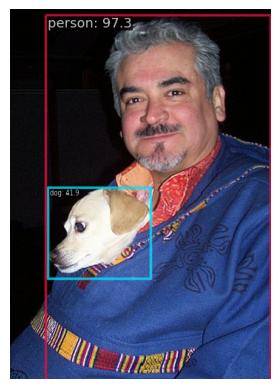

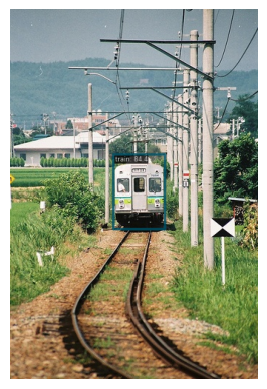

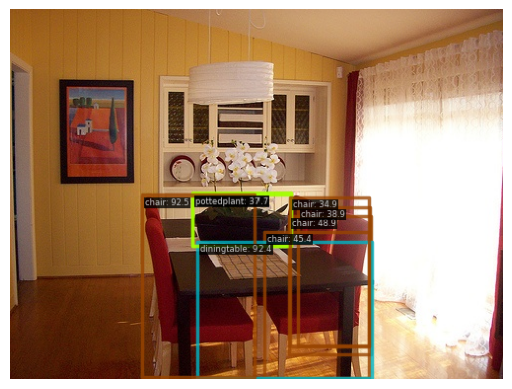

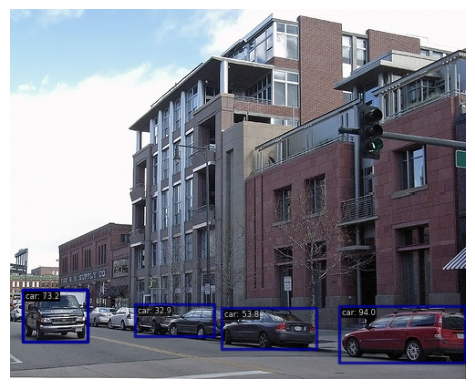

In [15]:
import mmcv
import torch
import numpy as np
from mmdet.apis import inference_detector, init_detector

# 1. 加载训练好的模型
config = 'configs/sparse_rcnn/sparse-rcnn_r50_fpn_1x_voc0712.py'
checkpoint = 'mymodels/sparse_rcnn/epoch_12.pth'
model = init_detector(config, checkpoint, device='cuda:0')


img_paths = ['data/VOCdevkit/VOC2007/JPEGImages/000001.jpg',
             'data/VOCdevkit/VOC2007/JPEGImages/000002.jpg',
             'data/VOCdevkit/VOC2007/JPEGImages/000006.jpg',
             'data/VOCdevkit/VOC2007/JPEGImages/000004.jpg']
for i in range(4):

    # 2. 推理图像
    img_path = img_paths[i]
    result = inference_detector(model, img_path)

    visualizer = VISUALIZERS.build(model.cfg.visualizer)
    visualizer.dataset_meta = model.dataset_meta  # 设置类别名称等元信息
    img = mmcv.imread(img_path)
    # 5. 显示并保存最终检测结果
    visualizer.add_datasample(
        'final',
        img[:, :, ::-1],
        data_sample=result,
        draw_gt=False,
        show=False,
        wait_time=0,
        out_file='final_predictions.jpg',
        # pred_score_thr=0.3,  # 可选：设置置信度阈值,
    )

    vis_img = visualizer.get_image()

    # 使用 matplotlib 显示图像
    plt.figure()  
    plt.imshow(vis_img)
    plt.axis('off')  # 关闭坐标轴
    plt.show()

# 搜集三张不在VOC数据集内包含有VOC中类别物体的图像，分别可视化并比较两个在VOC数据集上训练好的模型在这三张图片上的目标检测/实例分割结果（展示bounding box、instance mask、类别标签和得分）

## Mask R-CNN

Loads checkpoint by local backend from path: mymodels/mask_rcnn/epoch_8.pth


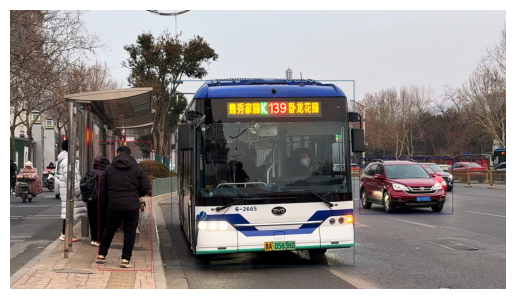

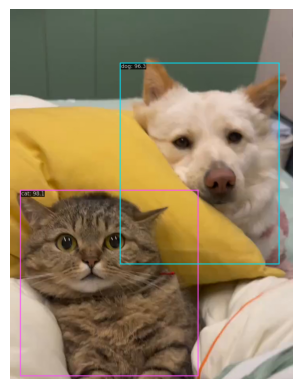

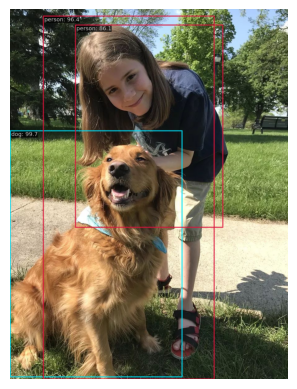

In [55]:
import mmcv
import numpy as np
import matplotlib.pyplot as plt
from mmdet.apis import init_detector, inference_detector
from mmengine.visualization import Visualizer
from mmengine.structures import InstanceData
import os

# 1. 初始化模型
config = 'configs/mask_rcnn/mask_rcnn_r50_fpn_1x_voc0712.py'
checkpoint = 'mymodels/mask_rcnn/epoch_8.pth'
model = init_detector(config, checkpoint, device='cuda:0')  # 或 'cpu'

# 2. 准备三张测试图像路径
test_images = [
    'bus_and_person.jpg',
    'dog_and_cat.jpeg',
    'person_and_dog.jpeg'
]

visualizer.bbox_line_width = 100  # 直接覆盖默认值

for img_path in test_images:
    result = inference_detector(model, img_path)

    visualizer = VISUALIZERS.build(model.cfg.visualizer)
    visualizer.dataset_meta = model.dataset_meta  # 设置类别名称等元信息
    
    img = mmcv.imread(img_path)

    # 5. 显示并保存最终检测结果
    visualizer.add_datasample(
        'final',
        img[:, :, ::-1],
        data_sample=result,
        draw_gt=False,
        show=False,
        wait_time=0,
        out_file=f'mask_rcnn_final_predictions_{img_path}.jpg',
    )

    vis_img = visualizer.get_image()

    # 使用 matplotlib 显示图像
    plt.figure()  
    plt.imshow(vis_img)
    plt.axis('off')  # 关闭坐标轴
    plt.show()

## Sparse R-CNN

Loads checkpoint by local backend from path: mymodels/sparse_rcnn/epoch_12.pth


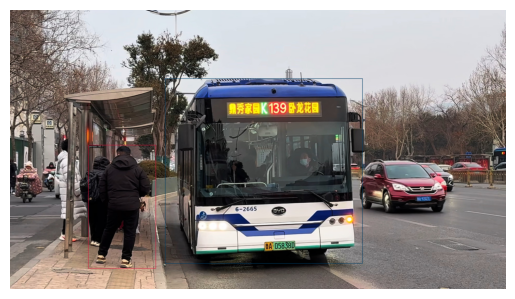

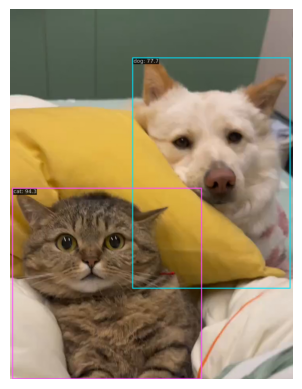

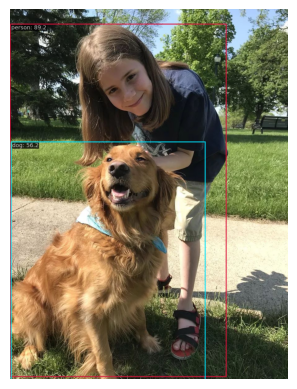

In [59]:
import mmcv
import numpy as np
import matplotlib.pyplot as plt
from mmdet.apis import init_detector, inference_detector
from mmengine.visualization import Visualizer
from mmengine.structures import InstanceData
import os

# 1. 加载训练好的模型
config = 'configs/sparse_rcnn/sparse-rcnn_r50_fpn_1x_voc0712.py'
checkpoint = 'mymodels/sparse_rcnn/epoch_12.pth'
model = init_detector(config, checkpoint, device='cuda:0')

# 2. 准备三张测试图像路径
test_images = [
    'bus_and_person.jpg',
    'dog_and_cat.jpeg',
    'person_and_dog.jpeg'
]

for img_path in test_images:
    result = inference_detector(model, img_path)

    visualizer = VISUALIZERS.build(model.cfg.visualizer)
    visualizer.dataset_meta = model.dataset_meta  # 设置类别名称等元信息
    
    img = mmcv.imread(img_path)

    # 5. 显示并保存最终检测结果
    visualizer.add_datasample(
        'final',
        img[:, :, ::-1],
        data_sample=result,
        draw_gt=False,
        show=False,
        wait_time=0,
        out_file=f'sparse_rcnn_final_predictions_{img_path}.jpg',
    )

    vis_img = visualizer.get_image()

    # 使用 matplotlib 显示图像
    plt.figure()  
    plt.imshow(vis_img)
    plt.axis('off')  # 关闭坐标轴
    plt.show()